In [130]:
import numpy as np
import matplotlib
from matplotlib  import pyplot as plt
import matplotlib.animation as animation
matplotlib.rcParams.update({'font.size': 22})

In [131]:
class Grid:
    def __init__(self,n):
        self.n = n
        self.h = 1/n
        self.uold = np.zeros([n+2,n+2]) #add 1 for boundary on both ends
        self.unew = np.zeros([n+2,n+2]) #add 1 for boundary on both ends
        self.res = np.zeros([n+2,n+2]) #Residual matrix
        self.err = np.zeros([n,n])  # error matrix
        self.q = np.zeros([n,n])  # forcing
        self.T = np.zeros([n+2,n+2])  # temperature

In [132]:
#relate temp to voids here
def diffConst(mg,l,K, D,phi1, alpha):
    g = mg[l-1]     # for last layer of MG??
    n = 2**(l)      
    Temp = np.zeros([n+2,n+2])*100+.2*t # our Temperature
    alpha = 0.000001*Temp # coefficient of thermal expansion for our sample. Making assumption it is constant for simplicity
    phi1 = phi1 - (alpha*phi1) # changing the void 
    if phi1[0,0] <=0: # ensures we don't have a "negative" void
      phi1 = 0*alpha 
    D = np.ones([n+2, n+2])*K*alpha*phi1 # updates the diffusion 
    return D # the new diffusion term

In [133]:
# user updates this function
def updateForce(mg,lmax,t,origin):
    # How fluid input from origin source changes throughout time (i.e. continuous flow, flows cuts off after certain time, etc)
    g = mg[lmax-1]
    n = 2**(lmax)
    g.q = np.zeros([n,n])

    #sets the 3 different starting conditions from where the fluid originates
    if origin == "edge":
      g.q[:,0] = 80*(t/2)**.5
      if t > 80.0:
        g.q[:,0] = 0.0
    
    elif origin == "center point":
      g.q[30:34,30:34] = 80*(t/2)**.5
      if t > 80.0:
        g.q[30:34,30:34] = 0.0

    elif origin == "edge point":
      g.q[30:34,0:2] = 80*(t/2)**.5
      if t > 80.0:
        g.q[30:34,0:2] = 0.0

In [134]:
def boundary(uu):
    #sets the 3 differend boundary conditions that could be explored. We focus on "rigid" in our writeup. 
    if(bc=='rigid'):
        uu[0:3,1:-1] = np.zeros(np.shape(uu[0:3,1:-1]))
        uu[-3:-1,1:-1] = np.zeros(np.shape(uu[-3:-1,1:-1]))

    if(bc=='dirichlet'):
        uu[0,1:-1] = -uu[1,1:-1]
        uu[-1,1:-1] = -uu[-2,1:-1]
        uu[1:-1,0] = -uu[1:-1,1] 
        uu[1:-1,-1] = -uu[1:-1,-2]
        uu[0,0] = -uu[1,1]
        uu[-1,0] = -uu[-2,1]
        uu[0,-1] = -uu[1,-2]
        uu[-1,-1] = -uu[-2,-2]
                
    if(bc=='periodic'):
        uu[0,1:-1] = uu[-2,1:-1]
        uu[-1,1:-1] = uu[1,1:-1]
        uu[1:-1,0] = uu[1:-1,-2]
        uu[1:-1,-1] = uu[1:-1,1]
        uu[0,0] = uu[-2,-2]
        uu[-1,0] = uu[1,-2]
        uu[0,-1] = uu[-2,1]
        uu[-1,-1] = uu[1,1]

In [135]:
def jacobi(mg,l,niter,dt,D): # added dt,K
    
    g = mg[l-1]
    #initialize iteration counter
    i = 0
    
    for i in range(niter):

        g.unew[1:-1,1:-1] = g.uold[1:-1,1:-1] + dt*D[1:-1,1:-1]*(g.uold[2:,1:-1]+g.uold[:-2,1:-1]+g.uold[1:-1,2:]+
                                                                 g.uold[1:-1,:-2]-4.0*g.uold[1:-1,1:-1])/(g.h**2)+g.q*dt  
        g.err[:,:] = g.uold[1:-1,1:-1] - g.unew[1:-1,1:-1]
        
        #update our step
        g.uold[1:-1,1:-1] = g.unew[1:-1,1:-1]
        boundary(g.uold)
        i += 1

In [136]:
def residual(mg,l):
    
    g = mg[l-1]
    
    g.res[1:-1,1:-1]= ((g.uold[2:,1:-1]+g.uold[:-2,1:-1]+g.uold[1:-1,2:]+g.uold[1:-1,:-2]-4.0*g.uold[1:-1,1:-1])/g.h**2 + g.q)
    boundary(g.res)

In [137]:
# need to figure out what's going on with the rhs equation
def restriction(mg,l):
    
    fine=mg[l-1]       #last layer
    coarse=mg[l-2]     #second to last layer
    
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+1./64*fine.res[0:-3:2,3:  :2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[1:-2:2,3:  :2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[2:-1:2,3:  :2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+1./64*fine.res[3:  :2,3:  :2]
    
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+1./64*fine.res[0:-3:2,0:-3:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[1:-2:2,0:-3:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[2:-1:2,0:-3:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+1./64*fine.res[3:  :2,0:-3:2]
    
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[0:-3:2,1:-2:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+9./64*fine.res[1:-2:2,1:-2:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+9./64*fine.res[2:-1:2,1:-2:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[3:  :2,1:-2:2]
    
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[0:-3:2,2:-1:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+9./64*fine.res[1:-2:2,2:-1:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+9./64*fine.res[2:-1:2,2:-1:2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[3:  :2,2:-1:2]
    
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+1./64*fine.res[0:-3:2,3:  :2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[1:-2:2,3:  :2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+3./64*fine.res[2:-1:2,3:  :2]
    coarse.res[1:-1,1:-1]=coarse.res[1:-1,1:-1]+1./64*fine.res[3:  :2,3:  :2]
    
    coarse.uold[:,:]=0

In [138]:
def prolongation(mg,l):
    
    fine=mg[l-1]
    
    coarse=mg[l-2]
    
    fine.err[:,:]=0
    
    fine.err[0:-1:2,0:-1:2]=fine.err[0:-1:2,0:-1:2]+1/16*coarse.uold[0:-2,0:-2]
    fine.err[0:-1:2,0:-1:2]=fine.err[0:-1:2,0:-1:2]+3/16*coarse.uold[1:-1,0:-2]
    fine.err[0:-1:2,0:-1:2]=fine.err[0:-1:2,0:-1:2]+3/16*coarse.uold[0:-2,1:-1]
    fine.err[0:-1:2,0:-1:2]=fine.err[0:-1:2,0:-1:2]+9/16*coarse.uold[1:-1,1:-1]

    fine.err[1:  :2,0:-1:2]=fine.err[1:  :2,0:-1:2]+3/16*coarse.uold[1:-1,0:-2]
    fine.err[1:  :2,0:-1:2]=fine.err[1:  :2,0:-1:2]+1/16*coarse.uold[2:  ,0:-2]
    fine.err[1:  :2,0:-1:2]=fine.err[1:  :2,0:-1:2]+9/16*coarse.uold[1:-1,1:-1]
    fine.err[1:  :2,0:-1:2]=fine.err[1:  :2,0:-1:2]+3/16*coarse.uold[2:  ,1:-1]

    fine.err[0:-1:2,1:  :2]=fine.err[0:-1:2,1:  :2]+3/16*coarse.uold[0:-2,1:-1]
    fine.err[0:-1:2,1:  :2]=fine.err[0:-1:2,1:  :2]+9/16*coarse.uold[1:-1,1:-1]
    fine.err[0:-1:2,1:  :2]=fine.err[0:-1:2,1:  :2]+1/16*coarse.uold[0:-2,2:  ]
    fine.err[0:-1:2,1:  :2]=fine.err[0:-1:2,1:  :2]+3/16*coarse.uold[1:-1,2:  ]

    fine.err[1:  :2,1:  :2]=fine.err[1:  :2,1:  :2]+9/16*coarse.uold[1:-1,1:-1]
    fine.err[1:  :2,1:  :2]=fine.err[1:  :2,1:  :2]+3/16*coarse.uold[2:  ,1:-1]
    fine.err[1:  :2,1:  :2]=fine.err[1:  :2,1:  :2]+3/16*coarse.uold[1:-1,2:  ]
    fine.err[1:  :2,1:  :2]=fine.err[1:  :2,1:  :2]+1/16*coarse.uold[2:  ,2:  ]
    
    fine.uold[1:-1,1:-1]=fine.uold[1:-1,1:-1]+fine.err[:,:]
    
    boundary(fine.uold)

In [139]:
def vcycle(mg,l,dt,D, phi1, alpha):
    if(l == 1): #our finest multigrid level
        D=diffConst(mg,l,K,D,phi1,alpha)
        jacobi(mg,l,10,dt,D)
    else:
        #for coarser multigrid levels
        D=diffConst(mg,l,K,D,phi1,alpha)
        jacobi(mg,l,3,dt,D)
        residual(mg,l)
        restriction(mg,l)
        vcycle(mg,l-1,dt,D,phi1,alpha)
        prolongation(mg,l)
        jacobi(mg,l,3,dt,D)

In [140]:
#runs the multigrid
def multigrid(mg,l,dt,K, nSteps, origin, phi1, alpha):
    
    i = 0
    norm = 1.0

    while (i < (itermax-1) and norm > eps):
        updateForce(mg,l,nSteps, origin)
        vcycle(mg,l,dt,K,phi1,alpha)
        norm = np.max(abs(mg[l-1].err))*n*n
        i += 1

In [141]:
lmax = 6 #the amount of levels our multigrid will use 
n = 2**lmax 
eps = 1e-15
itermax = 201

In [142]:
mg=[]
for l in range(1,lmax+1):
    n=2**l
    mg.append(Grid(n))

t =  0.0
t =  5.0
t =  10.0
t =  15.0
t =  20.0
t =  25.0
t =  30.0
t =  35.0
t =  40.0
t =  45.0
t =  50.0
t =  55.0
t =  60.0
t =  65.0
t =  70.0
t =  75.0
t =  80.0
t =  85.0
t =  90.0
t =  95.0
t =  100.0
t =  105.0
t =  110.0
t =  115.0
t =  120.0


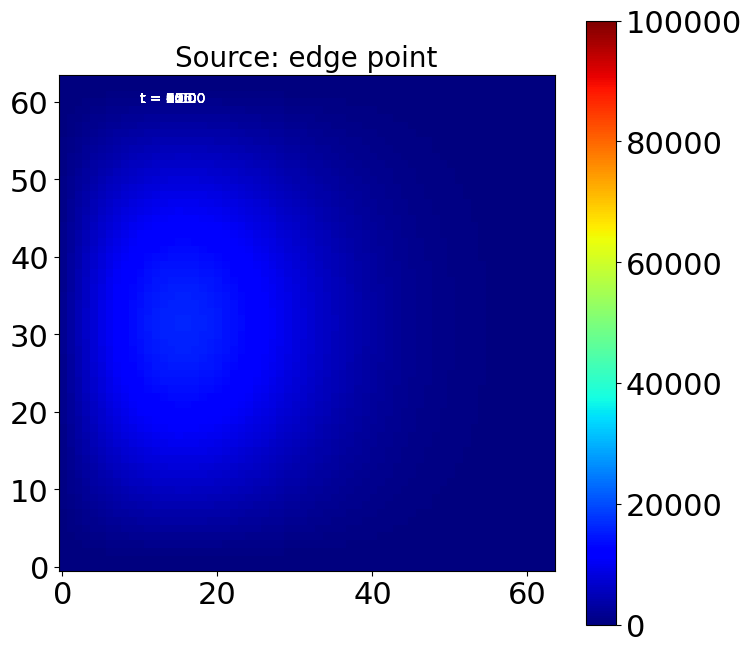

In [143]:
##INITIAL CONDITIONS

#All global variables used in functions in this program are defined here
#everthing that is lmax-1 is the finest grid
bc='rigid' #different boundary condtions can be chosen (periodic, dirichlet, rigid/inpermeable)
mg[lmax-1].q[:,:] = 0.0
mg[lmax-1].T[:,:] = 1
mg[lmax-1].uold[:,:] = 0

origin = "edge point"     #origin source of fluid: "edge", "center point", "edge point"
K = .05 #our "K" constant which accounts for different soil properties

#time of interest
nSteps = np.linspace(0,120,121)
dt = nSteps[1]-nSteps[0] # time step

#start figure for animation later
fig, ax = plt.subplots(figsize = (8,8), dpi=100)
plt.gca().invert_yaxis()

#some global variables having to do with diffusion
phi1 = .5 #our void volume fraction is initially .5. It goes down with time as the matrix expands
alpha = .1 #initialize coefficent of thermal expansion (constant). 
t = 0 #our time (initial)
D = np.ones([n+2, n+2]) #(initialization of diffusion coefficient)

ims = []

for i,t in enumerate(nSteps):
  g = mg[lmax-1]

  # calling multigrid for each time step
  multigrid(mg,lmax,dt,K, t, origin, phi1, alpha)              

  # only plot every 5 time units
  if t%5 == 0:
    print("t = ", t)
    ax.set_title("Source: %s"%origin, fontsize = 20)
    s = ax.imshow(mg[lmax-1].uold[1:-1,1:-1],cmap='jet',animated=True, vmin = 0, vmax = 100000)
    text = ax.annotate("t = %s"%t, (10,60), fontsize = 10, color = "white")
    ims.append([s,text])
    plt.gca().invert_yaxis()

fig.colorbar(s, ax =ax)

In [144]:
#makes and saves the animation movie file which visually shows the fluid spread.
ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
ani.save("diffusion_%s.mp4"%origin)